# Train a recurrent neural network to predict the position of the mouse in the v0,v1 coordinate system.

We train a model for each recording session.

We get the animal position in the v0,v1 coordinate system from `transform_xy_to_grid_representation()`.

We get the instantaneous firing rate of all our grid cells. 

We need to remove time-points with invalid values as the model can't deal with np.nan.


### Rate normalization

The firing rate of neuron is normalize for two reasons: all neurons have a similar contribution and values around 0 should facilitate learning. For each neuron, the rate vector is transform so that its mean is 0 and STD is 1. 

When doing inference, we will use the same transformation as during training to normalize the firing rate. This is because we often have a very poor estimate of the firing rate from short streches of data used for inference.

### v0,v1 as model labels

Each component of v0,v1 coordinate is periodic (circular data). To facilite learning, We decompose $v_{i}$ into $cos(v_{i})$ and $sin(v_{i})$. This way the values will range from -1 to 1 and the jumps from 360 to 0 degrees are avoided. You can think of $v_{i}$ as a circle with a radius of 1.

### Trained model

The trained model is saved in `session_name.grid_cell_rnn_model.pt` in each session directory.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import multivariate_normal
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from scipy.stats import wilcoxon, pearsonr
from scipy.signal import find_peaks
import torch
import numpy as np

from functions import *

# Break down of what goes into the model

<li>Input: Firing rate of many different grid cells as a function of time, split into sequences of 20 consequetive spike trains</li>
<li>Label: Location of the animal at that time point in toroidal coordinates</li>
<li>We first generate the training dataset, which uses animal position in the first random foraging</li>

In [140]:
a = np.load(firstRF)

In [142]:
a.shape

(90000, 8)

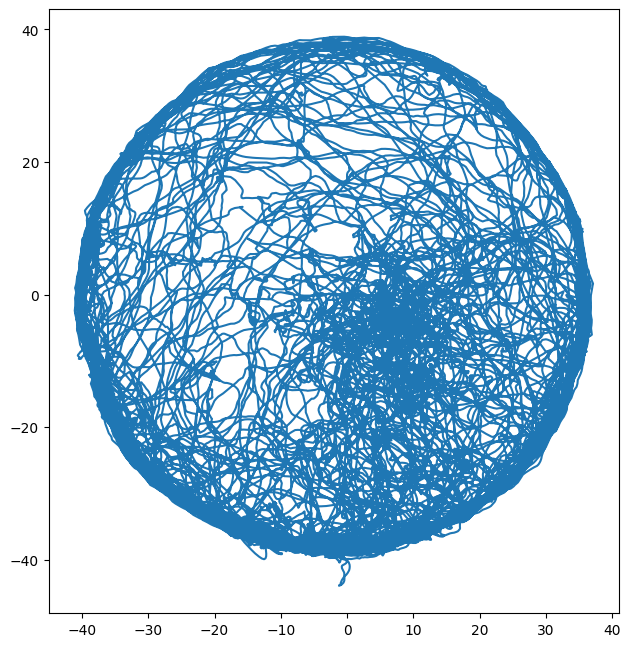

In [132]:
# Visualization of the first RF
ap = Animal_pose()
ap.load_pose_from_file(file_name=firstRF)
ori_inter = ap.intervals.inter

#ori_inter[0,0]=0.01 # so that the times of ifr windows matches the ap.pose times

ori_inter[0,0] = ap.pose[0,0]
ori_inter[0,1] = ap.pose[-1,0]+0.00000001

ap.set_intervals(ori_inter)

fig, ax = plt.subplots(figsize=(8,8))

ax.plot(ap.pose[:,1],ap.pose[:,2])
ax.set_aspect('equal') 

In [133]:
# Generate the simultaneously created grid cells
grid_param = {}
grid_param["n_cells"] = 20
grid_param["orientation"] = np.array([0,np.pi/3,np.pi/3*2])
grid_spacing = 35
grid_param["period"] = np.array([grid_spacing*np.cos(np.pi/6),grid_spacing*np.cos(np.pi/6),grid_spacing*np.cos(np.pi/6)])
grid_param["offset"] = np.random.rand(grid_param["n_cells"],2)*grid_param["period"][0]
peak_rates = np.random.normal(loc=15.0, scale=10.0, size=grid_param["n_cells"] )
peak_rates[peak_rates<5] = 5
grid_param["peak_rate"] = peak_rates

neuron_list = [Simulated_grid_cell(name=f"{i}", 
                                   offset=grid_param["offset"][i,:],
                                   orientation=grid_param["orientation"],
                                   period=grid_param["period"], 
                                   peak_rate=grid_param["peak_rate"][i], ap=ap)  for i in tqdm(range(grid_param["n_cells"]))]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


In [134]:
for n in neuron_list:
    
    n.spatial_properties.firing_rate_map_2d()

In [135]:
train_pose = np.stack([ap.pose[:,0],ap.pose[:,1],ap.pose[:,2],ap.pose[:,4]]).T # only consider the data that we will be using
train_pose.shape

(87407, 4)

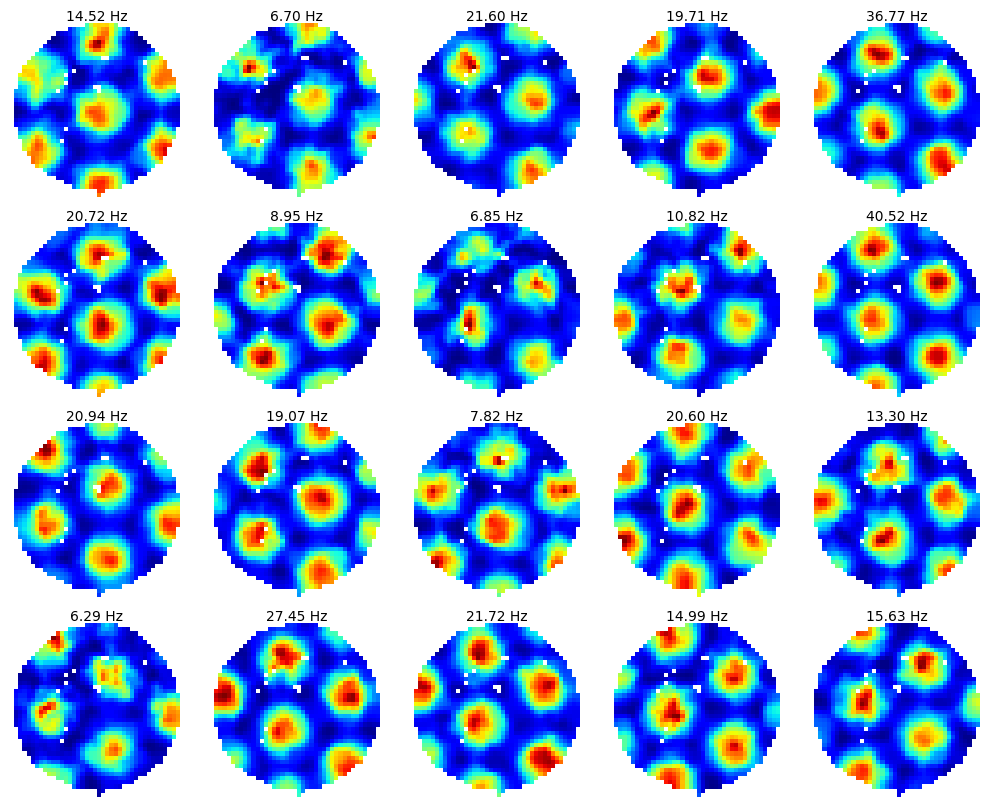

In [136]:
rowSize,colSize= 2,2
ncols=5
nrows=int(np.ceil(len(neuron_list)/ncols))
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


for i, n in enumerate(neuron_list):
    x = int(i/ncols)
    y = i%ncols
    ax = fig.add_subplot(mainSpec[x,y])
    plotMap(ax,n.spatial_properties.firing_rate_map,title = "{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)))

In [137]:
# Get the grid cell IFR during training
ifrList = []
for i, n in tqdm(enumerate(neuron_list)):
    n.spike_train.instantaneous_firing_rate(bin_size_sec=0.02,sigma=2)
    ifrList.append(n.spike_train.ifr[0])    
    if(i == 0):
        time = n.spike_train.ifr[2]
    n.spike_train.ifr=None # remove the reference to the numpy array, which can be deleted by garbage collector

ifr,time = (np.stack(ifrList,axis=0),time.round(4)) # added the round so that the numbers are not 0.019999999 but 0.02
train_ifr = ifr.T
train_time = time

20it [00:00, 220.57it/s]


Text(0, 0.5, 'Grid cells')

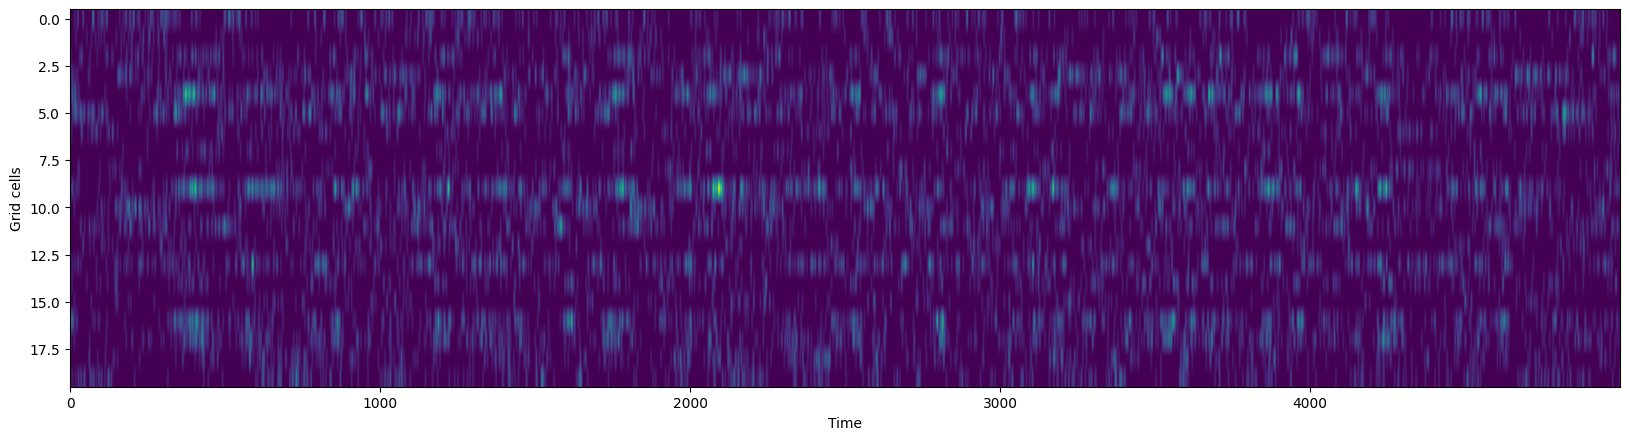

In [138]:
# Visualize the spike_train

fig, ax =plt.subplots(figsize=(20,5))
ax.imshow(train_ifr[:5000,:].T,aspect="auto",interpolation=None)
ax.set_xlabel('Time')
ax.set_ylabel('Grid cells')


In [139]:
train_ifr.shape,train_time.shape,train_pose.shape

((89999, 20), (89999,), (87407, 4))

Training is performed in the first random foraging, using 80% percent of data for training and 20% for testing. <br>
For the validation cohort, we use the second random foraging position data.

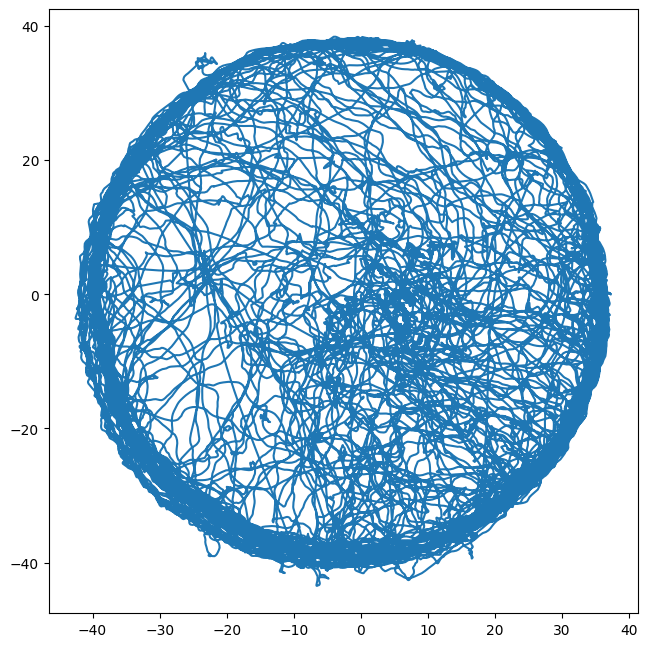

In [27]:
# Visualize animal position in the last random foraging

lap = Animal_pose()
lap.load_pose_from_file(file_name=lastRF)

ori_inter = lap.intervals.inter

lap.unset_intervals()
lap.set_intervals(ori_inter)


fig, ax = plt.subplots(figsize=(8,8))

ax.plot(lap.pose[:,1],lap.pose[:,2])
ax.set_aspect('equal') 

In [28]:
# Generate the test neuron list using simulated grid cells
# This neuron list uses position data from the second random foraging data

test_neuron_list = [Simulated_grid_cell(name=f"{i}", 
                                   offset=grid_param["offset"][i,:],
                                   orientation=grid_param["orientation"],
                                   period=grid_param["period"], 
                                   peak_rate=grid_param["peak_rate"][i], ap=lap)  for i in tqdm(range(grid_param["n_cells"]))]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


In [29]:
for n in test_neuron_list:
    n.spatial_properties.firing_rate_map_2d()

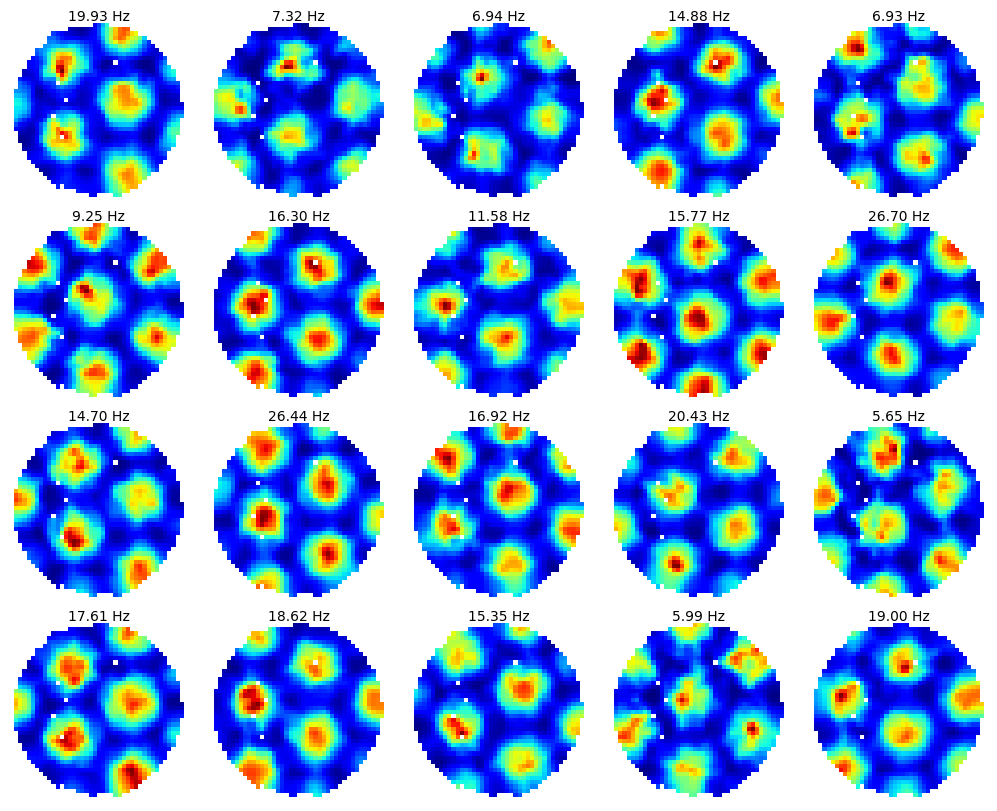

In [30]:
rowSize,colSize= 2,2
ncols=5
nrows=int(np.ceil(len(neuron_list)/ncols))
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


for i, n in enumerate(test_neuron_list):
    x = int(i/ncols)
    y = i%ncols
    ax = fig.add_subplot(mainSpec[x,y])
    plotMap(ax,n.spatial_properties.firing_rate_map,title = "{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)))

In [31]:
test_pose = np.stack([lap.pose[:,0],lap.pose[:,1],lap.pose[:,2],lap.pose[:,4]]).T # only consider the data that we will be using
test_pose.shape

(87750, 4)

In [32]:
ifrList = []
for i, n in tqdm(enumerate(test_neuron_list)):
    n.spike_train.instantaneous_firing_rate(bin_size_sec=0.02,sigma=2)
    ifrList.append(n.spike_train.ifr[0])    
    if(i == 0):
        time = n.spike_train.ifr[2]
    n.spike_train.ifr=None # remove the reference to the numpy array, which can be deleted by garbage collector

ifr,time = (np.stack(ifrList,axis=0),time.round(4)) # added the round so that the numbers are not 0.019999999 but 0.02
test_ifr = ifr.T
test_time = time

0it [00:00, ?it/s]

20it [00:00, 279.29it/s]


In [33]:
test_ifr.shape,time.shape,test_pose.shape

((87751, 20), (87751,), (87750, 4))